# Project: Investigate a Dataset (No-Show Appointments)

## Table of Contents
<a id='top'></a>

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#q1">Question 1</a></li>
<li><a href="#q2">Question 2</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

__The no-show appointments dataset__: This dataset contains data on 100,000 medical appointments in Brazil and centers around whether the patient made it to their appointment or was a no-show.

### Questions: 
- __Does age play a significant role in whether a patient attends their appointment? If so, could this be furthered explained by the gender breakdown of these age groups?__
- __What locations have the highest number of no-shows, and does this translate into higher no-show percentages?__

> __Note:__ Commented sections containing the word 'Source' identify resources referenced.

<a href="#top">__Back to top__</a>

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties
__The dataset, as we can see from the lines below, contains information pertaining to patients and a single medical appointment. Patients are not unique in that a single patient can have multiple appointments. Dataset details include:__
- __PatientId__: A unique identifier for an individual patient
- __AppointmentID__: A unique identifier for an single appointment
- __Gender__: The patient's gender (M/F)
- __ScheduledDay__: The day an appointment was scheduled
- __AppointmentDay__: The day of an appointment
- __Age__: The patient's age
- __Neighbourhood__: The location of the medical facility
- __Scholarship__: Whether the patient recieves assistance with their medical bills (0 = No, 1 = Yes)
- __Hipertension, Diabetes, Alcoholism, Handcap__: Whether the patient suffers from any of these ailments (0 = No, 1 = Yes)
- __SMS_received__: Whether the patient recieved a text message regarding their appointment (0 = No, 1 = Yes)
- __No-show__: Whether the patient made their appointment

__The dataset is already in a rather clean state and requires minimal changes to make it easier to analyze.__

<a href="#top">__Back to top__</a>

In [2]:
# Load medical appointment data.
df = pd.read_csv('medical_appointment_no_shows.csv')
# Print lines to check the state of the dataset.
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


### Data Cleaning
__Process__: 
The first step in the cleaning process is to change the PatientId from scientific notation to a standard integer form. Afterwards the column names are converted to lowercase, and dashes are replaced with underscores to make querying the dataset easier.

Additionally, date and time are separated into two separate columns for both the appointmentday and scheduledday columns. This is done as in their current states these columns are difficult to glean insights from, and by separating the two, the day of the week, time of the day, or other differences can be more easily calculated. Once these new columns are created, the day columns are converted to datetime objects, and the appointmentday and scheduledday columns are dropped as they are no longer needed.

Lastly, the age column contains values that appear erroneous. These ages are those that are less than 0 and greater than 110. The former is impossible, and the latter is improbable such as in in cases like patient ID 31963211613981 where their age (115) would make them one of the oldest humans on earth. In order to ensure that the information presented is as accurate as possible, ages below 0 and above 110 are removed.

In [3]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

# Change PatientId column data from float to int
df['PatientId'] = df['PatientId'].astype('int')

# Make column names lowercase and replace "-" with "_"
df.rename(columns = lambda x: x.lower().replace("-", "_"), inplace=True)

# Source: https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns

# Split day and time into two columns for schedule and appointment days 
# This will allow one to easily compare analyze time data as it is now in an easier format for comparisons
df['appointment_day'], df['appointment_time'] = df['appointmentday'].str.split('T', 1).str
df['scheduled_day'], df['scheduled_time'] = df['scheduledday'].str.split('T', 1).str

df['appointment_time'] = df['appointment_time'].apply(lambda x: x[:-1])
df['scheduled_time'] = df['scheduled_time'].apply(lambda x: x[:-1])

# Drop scheduledday and appointmentday columns as they are no longer needed.
df.drop(['scheduledday','appointmentday'], axis=1, inplace=True)

In [4]:
# Change day columns to datetime
df['scheduled_day'] = pd.to_datetime(df['scheduled_day'])
df['appointment_day'] = pd.to_datetime(df['appointment_day'])

# Get number of days between the schedule day and appointment day
df['days_between_appointment'] = (df['appointment_day'] - df['scheduled_day']).dt.days

# Remove ages below 0 and above 110.
df = df[(df['age'] > -1) & (df['age'] <= 110)]

In [5]:
# This function sets the title, x label, y label and text sizes for a graph
# title: string
# x_label: string
# y_label: string
# t_size: int
# x_size: int
# y_size

def set_labels(title='', x_label='', y_label='', t_size=15, x_size=12, y_size=12):
    plt.title(title, fontsize=t_size)
    plt.xlabel(x_label, fontsize=x_size)
    plt.ylabel(y_label, fontsize=y_size)
    
# This function sets a figure's size
# size: list
def set_size(size):
    plt.rcParams["figure.figsize"] = size

<a id='q1'></a>
## Exploratory Data Analysis

### Question 1: Does age play a significant role in showing up for an appointment? If so, could this be furthered explained by the gender breakdown of these age groups?

<a href="#top">__Back to top__</a>

__To see if there is any relation with age and showing up for an appointment, age groups first need to be established. For the sake of simplicity, two age groups will are created using the median age (37) as a divider. One group are those that are less than 37, and the other group are those 37 and up. Throughout this investigation they will be addressed as *younger* and *older* patients.__

__Once these groups are established, the number of no show appointments for each group is then calculated.__

In [6]:
# Obtain median age and then make two groups (older and younger)
age_median = df['age'].median()

# Create two dataframes based on the age median
# One below age median, another above and including the age median
younger_patients = df.query('age < @age_median')
older_patients = df.query('age >= @age_median')

# The number of older patients vs younger ones
number_older, number_younger = older_patients.shape[0], younger_patients.shape[0]

In [7]:
# Based on this information alone, what age group has the most no-shows?

older_no_shows = older_patients.query('no_show == "Yes"').shape[0]
younger_no_shows = younger_patients.query('no_show == "Yes"').shape[0]

__Based on the graph below we can see that younger patients (those under the age of 37) have more missed appointments than older (37 and older) patients.__

>__Note__: The numbers expressed in the following two graphs are for number of visits and not unique individuals.

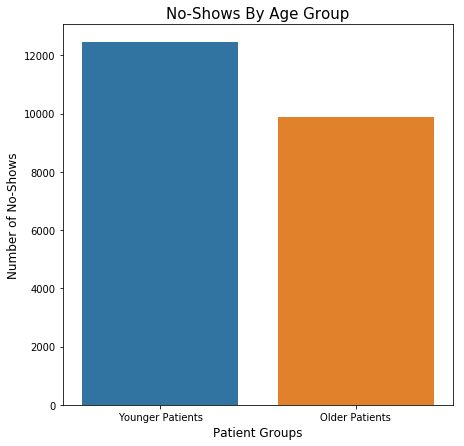

In [8]:
# Set figure size
set_size([7,7])

# Plot age group data and add titles and labels
sns.barplot(data=[[younger_no_shows], [older_no_shows]])
set_labels('No-Shows By Age Group', 'Patient Groups', 'Number of No-Shows')
plt.xticks([0,1], ['Younger Patients', 'Older Patients']);

__Below we can see what percentage of visits were no-shows for each age group. This information is presented in two side-by-side pie charts to clearly show the difference in attendence by age group.__

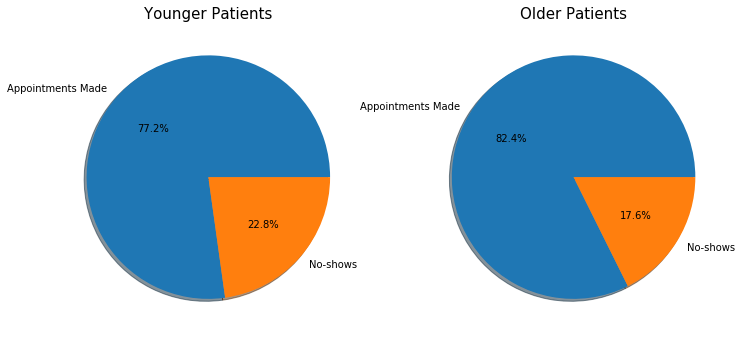

In [9]:
# Pie chart source: https://matplotlib.org/gallery/pie_and_polar_charts/pie_demo2.html#sphx-glr-gallery-pie-and-polar-charts-pie-demo2-py
from matplotlib.gridspec import GridSpec

# Assign labels for the pie charts.
labels = 'Appointments Made', 'No-shows'

# For both age groups, retrieve results on the number of no-shows versus non-no-shows.
younger_attendance = [younger_patients.query('no_show == "No"').shape[0], younger_patients.query('no_show == "Yes"').shape[0]]
older_attendance = [older_patients.query('no_show == "No"').shape[0], older_patients.query('no_show == "Yes"').shape[0]]

# Create a subplot to allow both graphs to be placed side by side.
grid = GridSpec(1, 2)
# Change figure size.
set_size([12, 12])

# Plot younger age group data
plt.subplot(grid[0, 0], aspect=1)
plt.pie(younger_attendance, labels=labels, autopct='%1.1f%%', shadow=True)
set_labels('Younger Patients')

# Plot older age group data
plt.subplot(grid[0, 1], aspect=1)
plt.pie(older_attendance, labels=labels, autopct='%1.1f%%', shadow=True)
set_labels('Older Patients')
plt.xticks(fontsize=15);


__From these charts, we can infer that older patients are around five percent more likely than younger patients to make their appointments. However in order to more clearly understand this information, we need to know how many unique patients are a part of each group. Additionally, could gender make-up offer some greater insights into these numbers?__

__Below the counts of unique individuals for each gender is calculated and stored within their own variable.__

In [10]:
# Gender counts for age groups
genders_younger = pd.DataFrame(younger_patients[~younger_patients['patientid'].duplicated()].groupby('gender').count()['no_show']).reset_index()
genders_older = pd.DataFrame(older_patients[~older_patients['patientid'].duplicated()].groupby('gender').count()['no_show']).reset_index()

__This count information for age group and genders is then arranged into the graphs below where we can see that women make up a majority of the unique patients. Additionally older women seem to attend medical appointments more than twice as often as men. However younger men seem to attend more often than older men while the number of women appears to be slightly less in the younger age group.__

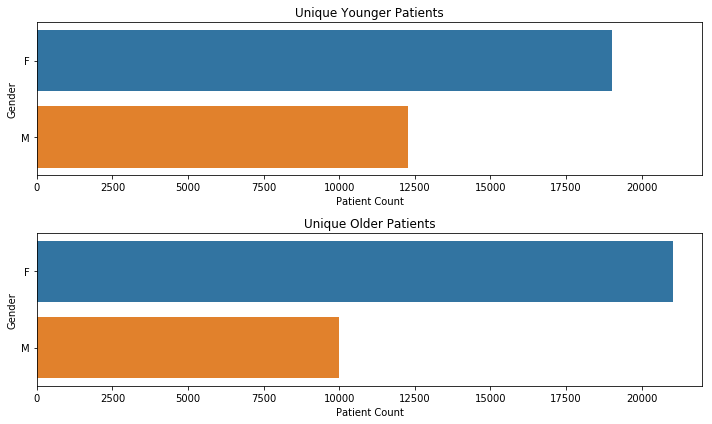

In [11]:
# Graph the number of unique patients by age group.

# Use subplots to plot both graphs in the same cell block
# Assign the figure size
set_size([10,6])
f, (ax1, ax2) = plt.subplots(2)

# Source: https://stackoverflow.com/questions/25212986/how-to-set-some-xlim-and-ylim-in-seaborn-lmplot-facetgrid
# Plot gender data for younger patients
# Assign lables and limit x range to match older patients data
sns.barplot(y='gender', x='no_show', data=genders_younger, ax=ax1)
ax1.set(title='Unique Younger Patients', xlabel='Patient Count', ylabel='Gender', xlim=(0, 22000))

# Plot gender data for younger patients
# Assign lables and limit x range to match younger patients data
sns.barplot(y='gender', x='no_show', data=genders_older, ax=ax2)
ax2.set(title='Unique Older Patients', xlabel='Patient Count', ylabel='Gender', xlim=(0, 22000))
plt.tight_layout()

__Based on the information detailed above, we can infer that older patients have lower no-show rates, but might this attributed to one sex having a higher attendance than another?__

__To explore this idea, the percentage of no-show appointments by gender is gathered for each age group. That information is then combined into a single dataframe to be visualized further on.__

In [12]:
# Find number of no-shows by Gender to see if the difference in attendance by age can be further explained by gender

# For both age groups take the number of appointments that have been no-shows
# Afterwards obtain the percentage of no-shows out of patients by gender
genders_younger_no_shows = younger_patients[(younger_patients['no_show'] == 'Yes')].groupby('gender').count()['sms_received'] \
                          / younger_patients.groupby('gender').count()['sms_received'] * 100

genders_older_no_shows = older_patients[(older_patients['no_show'] == 'Yes')].groupby('gender').count()['sms_received'] \
                          / older_patients.groupby('gender').count()['sms_received'] * 100

# Source: https://stackoverflow.com/questions/26097916/python-best-way-to-convert-a-pandas-series-into-a-pandas-dataframe
# Convert the two series above into dataframes
genders_younger_no_shows = pd.DataFrame({'gender':genders_younger_no_shows.index, 'number_of_patients':genders_younger_no_shows.values})
genders_older_no_shows = pd.DataFrame({'gender':genders_older_no_shows.index, 'number_of_patients':genders_older_no_shows.values})

# Add a new column to each to show what age group they belong to and then merge the two dataframes
genders_younger_no_shows['age_group'] = 'younger'
genders_older_no_shows['age_group'] = 'older'

# Combine dataframes
no_show_groups = pd.concat([genders_younger_no_shows, genders_older_no_shows])

__Going by what is seen, despite men appearing to have the lower no-show rate from both age groups, the difference between male and female patients making their appointments is rather slim.__

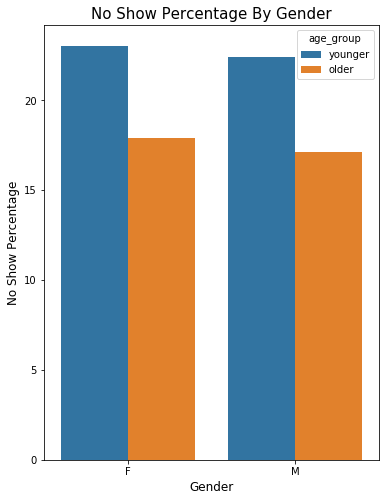

In [13]:
# Source: https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots

# Graph No Show Percentage by Gender for unique patients
set_size([6,8])
sns.barplot(x='gender', y='number_of_patients', hue='age_group', data=no_show_groups)
set_labels('No Show Percentage By Gender', 'Gender', 'No Show Percentage');

__Below all of this inforamtion is brought together to give a more comprehensive view of how gender and age correlate to no show appointments. As one can see, no shows are most prevelant at a younger age especially among women which is possibly due to women scheduling more appointments.__

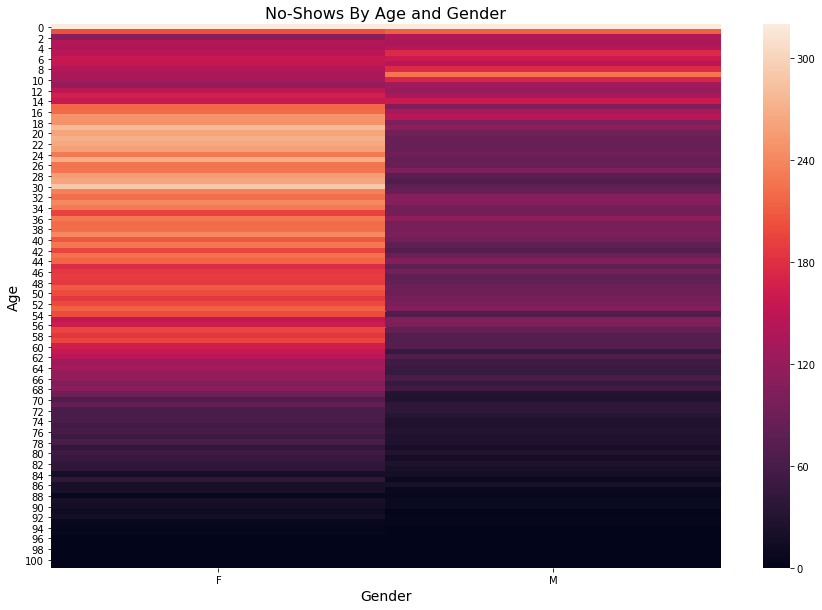

In [14]:
# Source: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html

no_show_heat = df.copy().replace({'no_show': {"Yes": 1, "No": 0}})
no_show_heat = no_show_heat.groupby(['age', 'gender'])['no_show'].sum().reset_index().pivot('age', 'gender', 'no_show').fillna(0)
# Set figure size
set_size([15,10])
sns.heatmap(no_show_heat)
set_labels('No-Shows By Age and Gender', 'Gender', 'Age', 16, 14, 14)
#plt.legend();

<a id='q2'></a>
### Question 2: What locations have the highest number of no-shows, and does this translate into higher no-show percentages?

<a href="#top">__Back to top__</a>

__To begin, a new temporary dataframe is created to allow for data manipulation. Afterwards the number of no-shows per neighbourhood is collected into its own dataframe. The same is then done for all appointments per neighbourhood. Then that data is combined into one. This data is then sorted to allow for easier consumption of information.__

In [15]:
# Copied version of original dataframe for used to create other dataframes
z = df.copy()

# Dataframe of neighbourhoods and no shows. Only inlcudes missed appointment. 
neighbourhood_no_shows = pd.DataFrame(z.groupby(['neighbourhood'])['no_show'].apply(lambda x: x[x.str.contains('Yes')].count()).reset_index())

# Dataframe of all neighbourhoods and appointments made. Includes those attended and no_shows
# Source: https://stackoverflow.com/questions/31649669/pandas-groupby-count-string-occurrence-over-column
neighborhood_all_appointments = pd.DataFrame(z.groupby(['neighbourhood'])['no_show'].count()).reset_index()
neighborhood_all_appointments.columns = ['neighbourhood', 'scheduled']
neighbourhood_numbers = neighbourhood_no_shows.merge(neighborhood_all_appointments, how='left', on='neighbourhood')

# Sort dataframe such that the highest number of no_shows is on top
neighbourhood_numbers.sort_values('scheduled', ascending=True, inplace=True)

__Below, the number of appointments and no-shows by neighbourhood is presented together. We can see what appears to be considerable variation in appointments and no-shows by location. One might infer that the higher up on the graph we go, the greater population density that neighbourhood has.__

__This however does shed light on which area has the highest number of no-shows.__

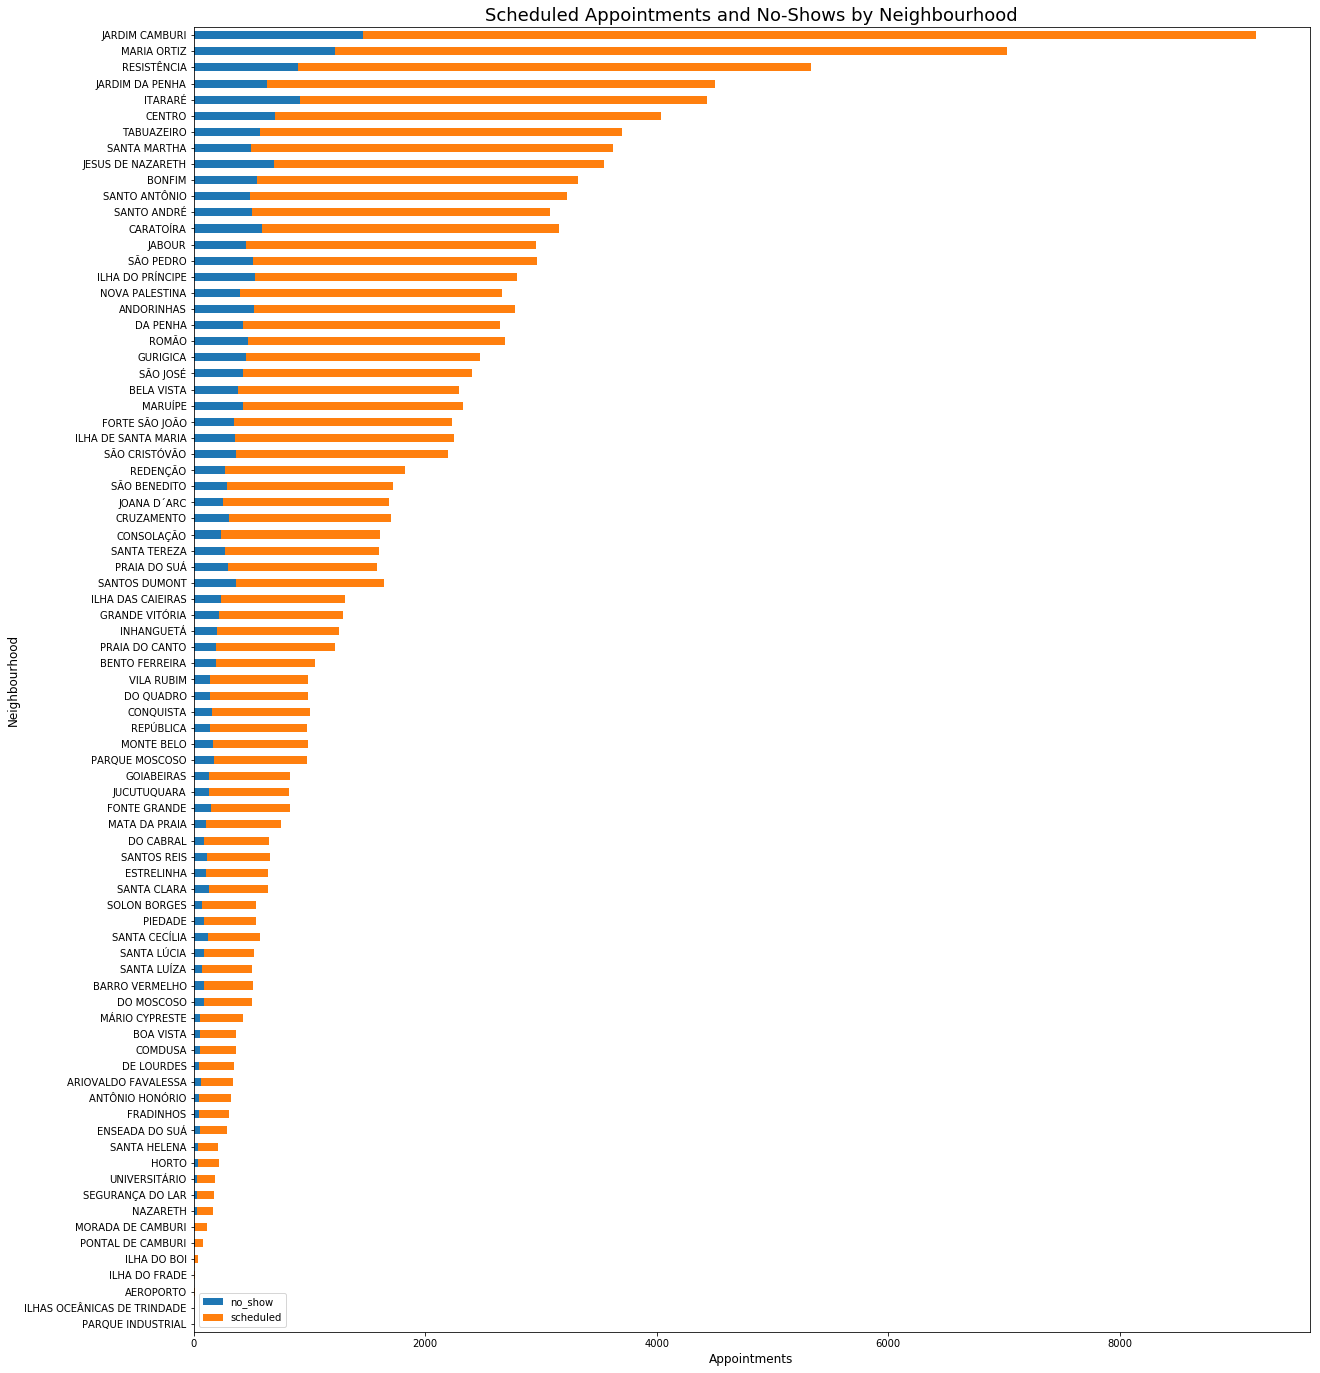

In [16]:
# Source: https://stackoverflow.com/questions/50900053/plot-a-stacked-bar-chart-matplotlib-pandas
# Set figure size
set_size([20,24])

# Plot data
neighbourhood_numbers.plot(x='neighbourhood', y=['no_show', 'scheduled'], kind='barh', stacked=True)

# Set graph labels
set_labels('Scheduled Appointments and No-Shows by Neighbourhood', 'Appointments', 'Neighbourhood', 18, );

__To make that determination, no-show data for each neighbourhood is gathered and then plotted to help us uncover which places have the highest rate of missed medical appointments.__

In [17]:
# Make a copy of neighbourhood_numbers to make changes
nn_copy = neighbourhood_numbers.copy()

# Add a new column to this dataframe to get the no-show percentage for each neighbourhood
nn_copy['no_show_percent'] = round(nn_copy['no_show'] / nn_copy['scheduled'] * 100, 2)
# Sort values based on the no_show_percent column to better display results
nn_copy.sort_values('no_show_percent', inplace=True)

In [18]:
print("No-show mean percentage:", nn_copy['no_show_percent'].mean())

No-show mean percentage: 20.542345679012346


__With the exception of the outlier, Ilhas Oceânicas de Trindade as it has only had two appointments, the no-show percentge spread is not considerably wide. The average no-show percentage is around twenty so one could infer that roughly 1 in 5 patients does not make their appointment.__

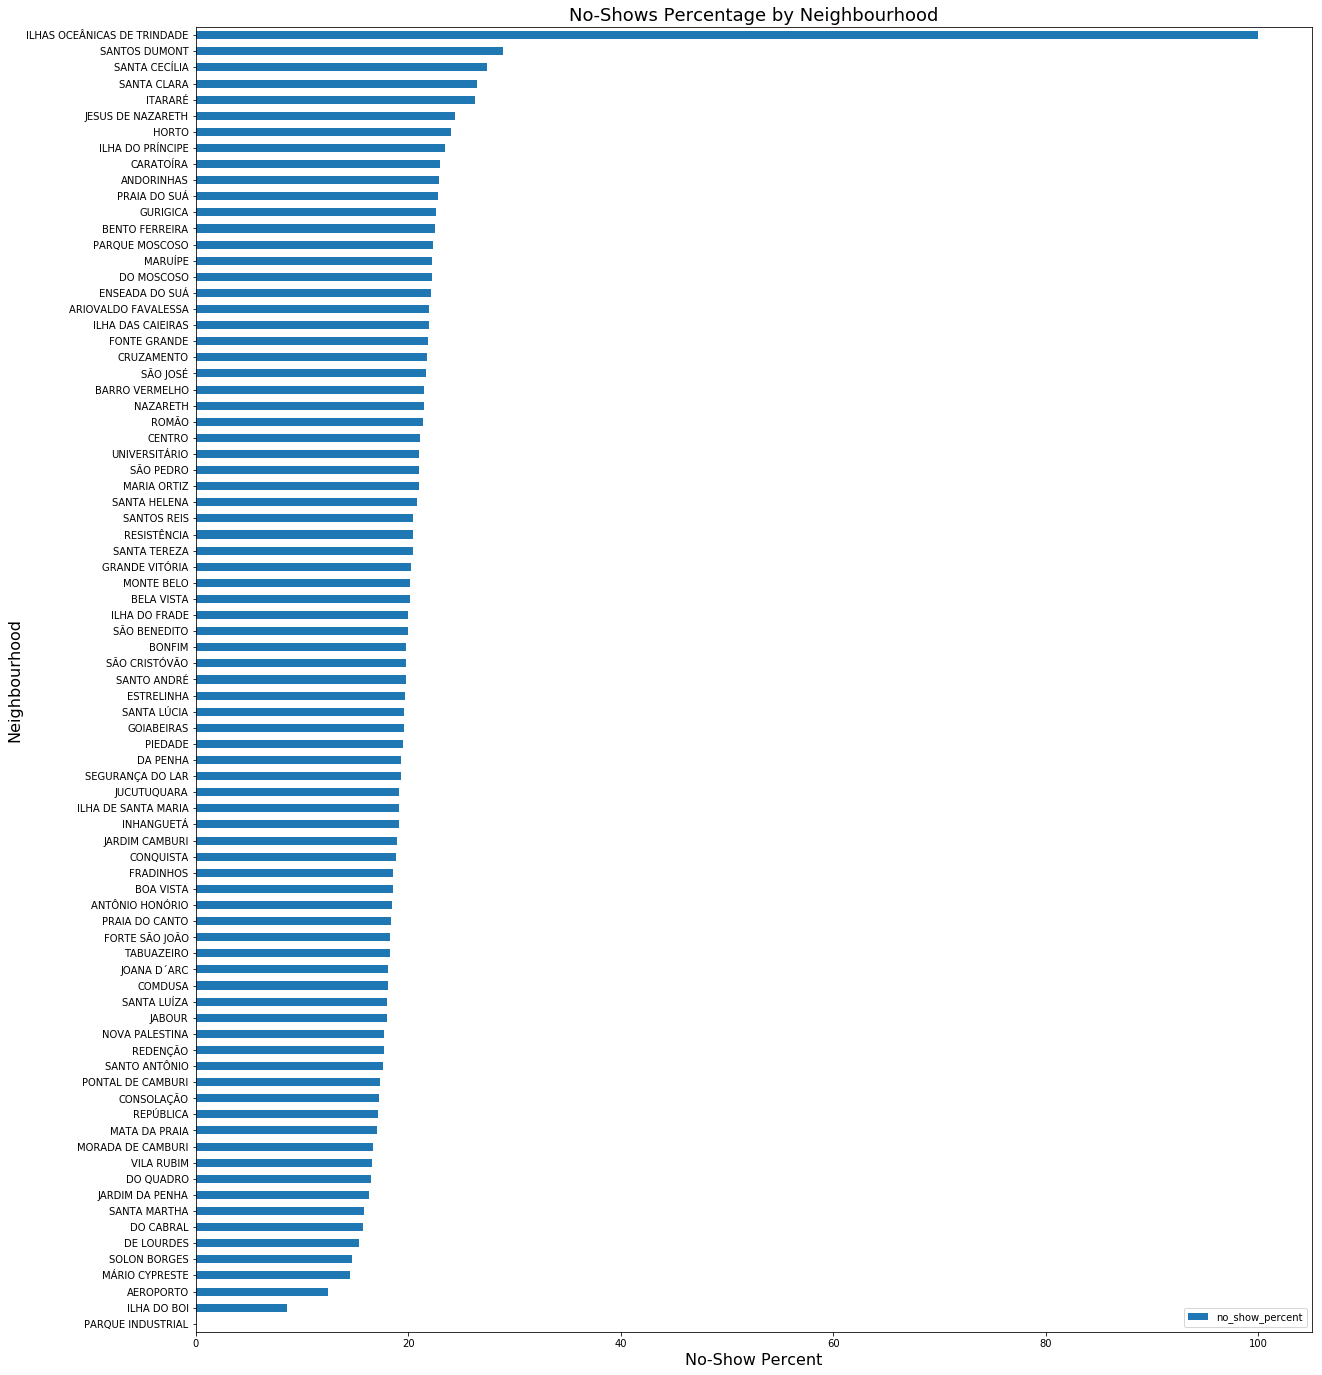

In [19]:
set_size([20,24])
nn_copy.plot(x='neighbourhood', y=['no_show_percent'], kind='barh')
set_labels('No-Shows Percentage by Neighbourhood', 'No-Show Percent', 'Neighbourhood', 18, 16, 16);

<a id='conclusions'></a>
## Conclusions
__From the information above, several inferences can be made:__
- Women make medicial appointments in much larger numbers than men, but they appear to have higher no-show rates than men until later in life.
- It appears that younger patients are around 5% more likely to miss medical appointments in Brazil.
- Increasing age correlates to fewer no-shows for both men and women.
- Higher no-show numbers correlates with neighbourhoods where the most appointments are made. This could be a clue to the population size of these areas, size of the clinics, reputation of the clinics, or ease of access to the clinics by means of transportation.
- No show-percentage by neighbourhood does not appear to directly correlate to the number of appointments. However neighbourhoods with lower appointment numbers could have significantly high no-show rates due to one no-show being much more impactful than it is for clinics with more appointments. 

### Limitations
__Difficulties and limitations:__
- The data does not include the reason why appointments were scheduled.
- The data is only for one country.
- It would be helpful to have more information on the financial status of the patient and/or neighbourhoods.
- Additonal information for neighbourhoods would be helpful such as population, size, whether public transportation is available, etc.
- The size of the clinic would be useful information.

<a href="#top">__Back to top__</a>

__Resources:__
- https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns
- https://matplotlib.org/gallery/pie_and_polar_charts/pie_demo2.html#sphx-glr-gallery-pie-and-polar-charts-pie-demo2-py
- https://stackoverflow.com/questions/25212986/how-to-set-some-xlim-and-ylim-in-seaborn-lmplot-facetgrid
- https://stackoverflow.com/questions/26097916/python-best-way-to-convert-a-pandas-series-into-a-pandas-dataframe
- https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots
- https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html
- https://stackoverflow.com/questions/31649669/pandas-groupby-count-string-occurrence-over-column
- https://stackoverflow.com/questions/50900053/plot-a-stacked-bar-chart-matplotlib-pandas